* This notebook was made to investigate when mixing in the river is dominant by tides and when by river-induced mixing or winds in an averaged sense and also at different instantaneous time.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import StraTimeSeries as sts
import DetermineEdgePlume as DEP
import R_mixStuff as RS
from R_mixStuff import sites
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
%matplotlib inline

In [2]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 

In [3]:
## load grid_T model results
octriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_T.nc')
mayriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_T.nc')
janriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_T.nc')

octall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
mayall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc')
janall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc')

octnowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
maynowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_T.nc')
jannowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_T.nc')

octnotide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_T.nc')
maynotide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015notides/may2015notides_T.nc')
jannotide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016notides/jan2016notides_T.nc')

octnof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_T.nc')
maynof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nof/may2015nof_T.nc')
jannof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nof/jan2016nof_T.nc')

In [4]:
## load grid_U model results
octriver_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_U.nc')
mayriver_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_U.nc')
janriver_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_T.nc')

octall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc')
mayall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_U.nc')
janall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_U.nc')

octnowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_U.nc')
maynowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_U.nc')
jannowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_U.nc')

octnotide_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_U.nc')
maynotide_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015notides/may2015notides_U.nc')
jannotide_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016notides/jan2016notides_T.nc')

octnof_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_U.nc')
maynof_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nof/may2015nof_U.nc')
jannof_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nof/jan2016nof_U.nc')

In [5]:
## load grid_V model results
octriver_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_V.nc')
mayriver_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_V.nc')
janriver_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_T.nc')

octall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc')
mayall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_V.nc')
janall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_V.nc')

octnowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_V.nc')
maynowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_V.nc')
jannowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_V.nc')

octnotide_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_V.nc')
maynotide_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015notides/may2015notides_V.nc')
jannotide_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016notides/jan2016notides_T.nc')

octnof_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_V.nc')
maynof_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nof/may2015nof_V.nc')
jannof_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nof/jan2016nof_V.nc')

In [6]:
def get_Rmix(gridT1,gridT2,gridT3,gridT4,gridT5,tst,ted,dep_ind):
    """This function was made to get the time averaged Rmix"""
    rmix = {};
    for grid_T,st,in zip([gridT1,gridT2,gridT3,gridT4,gridT5],['onlyriver','river+tides',\
                        'river+winds','nof','all']):
        S = grid_T.variables['vosaline']
        lon = grid_T.variables['nav_lon']
        dep = grid_T.variables['deptht']

        S_ave = np.nanmean(S[tst:ted+1],axis = 0)
        rmix[st] = RS.R_mixAve(S_ave,np_mask,dep_ind)
    return rmix

In [7]:
def rmix_each(river_T,nowind_T,notide_T,nof_T,all_T,tst,ted,dep_ind):
    """This function was made to plot the averaged Rmix spatial pattern
    of each run case"""
    rmix = get_Rmix(river_T,nowind_T,notide_T,nof_T,all_T,tst,ted,dep_ind)
    lon = all_T.variables['nav_lon']
    lat = all_T.variables['nav_lat']
    fig = plt.figure(figsize=(24,20))
    gs = gridspec.GridSpec(4, 2,width_ratios=[1,1], height_ratios=[1,1,1,1])  
    gs.update(hspace=0.2, wspace=0.1)
    levels = [0.1,0.3,0.5,0.7,0.9]
    for ti, ax in zip(['onlyriver','river+tides','river+winds','nof','all'],[fig.add_subplot(gs[0,0]),fig.add_subplot(gs[0,1]),\
                     fig.add_subplot(gs[1,0]),fig.add_subplot(gs[1,1]),fig.add_subplot(gs[2,0])]):
        CS = ax.contourf(lon[:],lat[:],rmix[ti],levels,cmap = 'jet',extend='both')
        CS2 = ax.contour(CS, colors = 'k',hold='on',linewidths=(2,))
        cbar = fig.colorbar(CS,ax = ax)
        cbar.add_lines(CS2)
        cbar.set_label('Rmix')
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_title(ti)
        ax.set_xlim([-124.,-122.8])
        ax.set_ylim([48.9,49.5])
    ax = fig.add_subplot(gs[2,1])
    CS = ax.contourf(lon[:],lat[:],rmix['river+winds']-rmix['river+tides'],levels = [-0.2,-0.15,-0.1,-0.05,0,0.05,0.1,0.15,0.2],cmap = 'jet',extend='both')
    CS2 = ax.contour(CS, colors = 'k',hold='on',linewidths=(2,))
    cbar = fig.colorbar(CS,ax = ax)
    cbar.add_lines(CS2)
    cbar.set_label('Rmix')
    ax.set_title('river+winds-(river+tides)')
    
    ax = fig.add_subplot(gs[3,0])
    CS = ax.contourf(lon[:],lat[:],rmix['all']-rmix['river+tides'],levels = [-0.2,-0.15,-0.1,-0.05,0,0.05,0.1,0.15,0.2],cmap = 'jet',extend='both')
    CS2 = ax.contour(CS, colors = 'k',hold='on',linewidths=(2,))
    cbar = fig.colorbar(CS,ax = ax)
    cbar.add_lines(CS2)
    cbar.set_label('Rmix')
    ax.set_title('all-(river+tides)')
    
    ax = fig.add_subplot(gs[3,1])
    CS = ax.contourf(lon[:],lat[:],rmix['all']-rmix['river+winds'],levels = [-0.2,-0.15,-0.1,-0.05,0,0.05,0.1,0.15,0.2],cmap = 'jet',extend='both')
    CS2 = ax.contour(CS, colors = 'k',hold='on',linewidths=(2,))
    cbar = fig.colorbar(CS,ax = ax)
    cbar.add_lines(CS2)
    cbar.set_label('Rmix')
    ax.set_title('all-(river+winds)')
    
    for ax in [fig.add_subplot(gs[2,1]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[3,1])]:
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')

        ax.set_xlim([-123.2,-122.8])
        ax.set_ylim([48.9,49.3])

In [8]:
def salinity_profile_update(grid_T,tst,ted,dep_ind,np_mask,string,rmin = 0,rmax =1.0 ):
    """This function was to plot salinity transect and Rmix mainly in the river for 
    winds, tides, and all cases that should be selected"""
    fig = plt.figure(figsize=(16, 6))
    G = gridspec.GridSpec(2, 2,width_ratios=[1, 1], height_ratios=[1,1]) 
    G.update(hspace=0., wspace=0.3)
    axes_1 =fig.add_subplot(G[0,0]) ## rmix
    axes_2 = fig.add_subplot(G[1,0],sharex=axes_1) ## salinity profile
    axes_3 = fig.add_subplot(G[:,1]) ## whole contour
    plt.setp(axes_1.get_xticklabels(), visible=False)
    S_small = {};

    S = grid_T.variables['vosaline']
    S_small[string] =np.ma.masked_array(np.nanmean(S[tst:ted+1,:,36,4:123],axis=0),mask =np_mask[:,36,4:123])
    dep = grid_T.variables['deptht']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    mesh = axes_2.contourf(lon[36,4:123],dep[:],S_small[string][:],np.arange(0,34,1),cmap='jet')
    axes_2.set_ylim([dep[-20],dep[0]])
    axes_2.set_xlim([lon[36,4],lon[36,123]])
    
    S_ave =np.ma.masked_array(np.nanmean(S[tst:ted+1],axis=0),mask = np_mask)
    mesh = axes_3.contourf(lon[:],lat[:],S_ave[0],np.arange(0,34,1),cmap='jet')
    cbar = fig.colorbar(mesh,ax = axes_3,orientation = 'vertical')
    axes_3.plot(lon[36,4:123],lat[36,4:123],'k-')    
    viz_tools.plot_land_mask(axes_3,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(axes_3, grid6, coords = 'map')
    axes_3.set_xlim([-124.,-122.8])
    axes_3.set_ylim([48.9,49.5])
    axes_3.set_title(string)
    
    r_mix = get_Rmix(grid_T,grid_T,grid_T,grid_T,grid_T,tst,ted,dep_ind)
    axes_1.plot(lon[36,4:123],r_mix[string][36,4:123],'r-*')
    axes_1.set_ylim([rmin,rmax])
    axes_1.set_title(string)
    return r_mix, S_ave

* weak winds

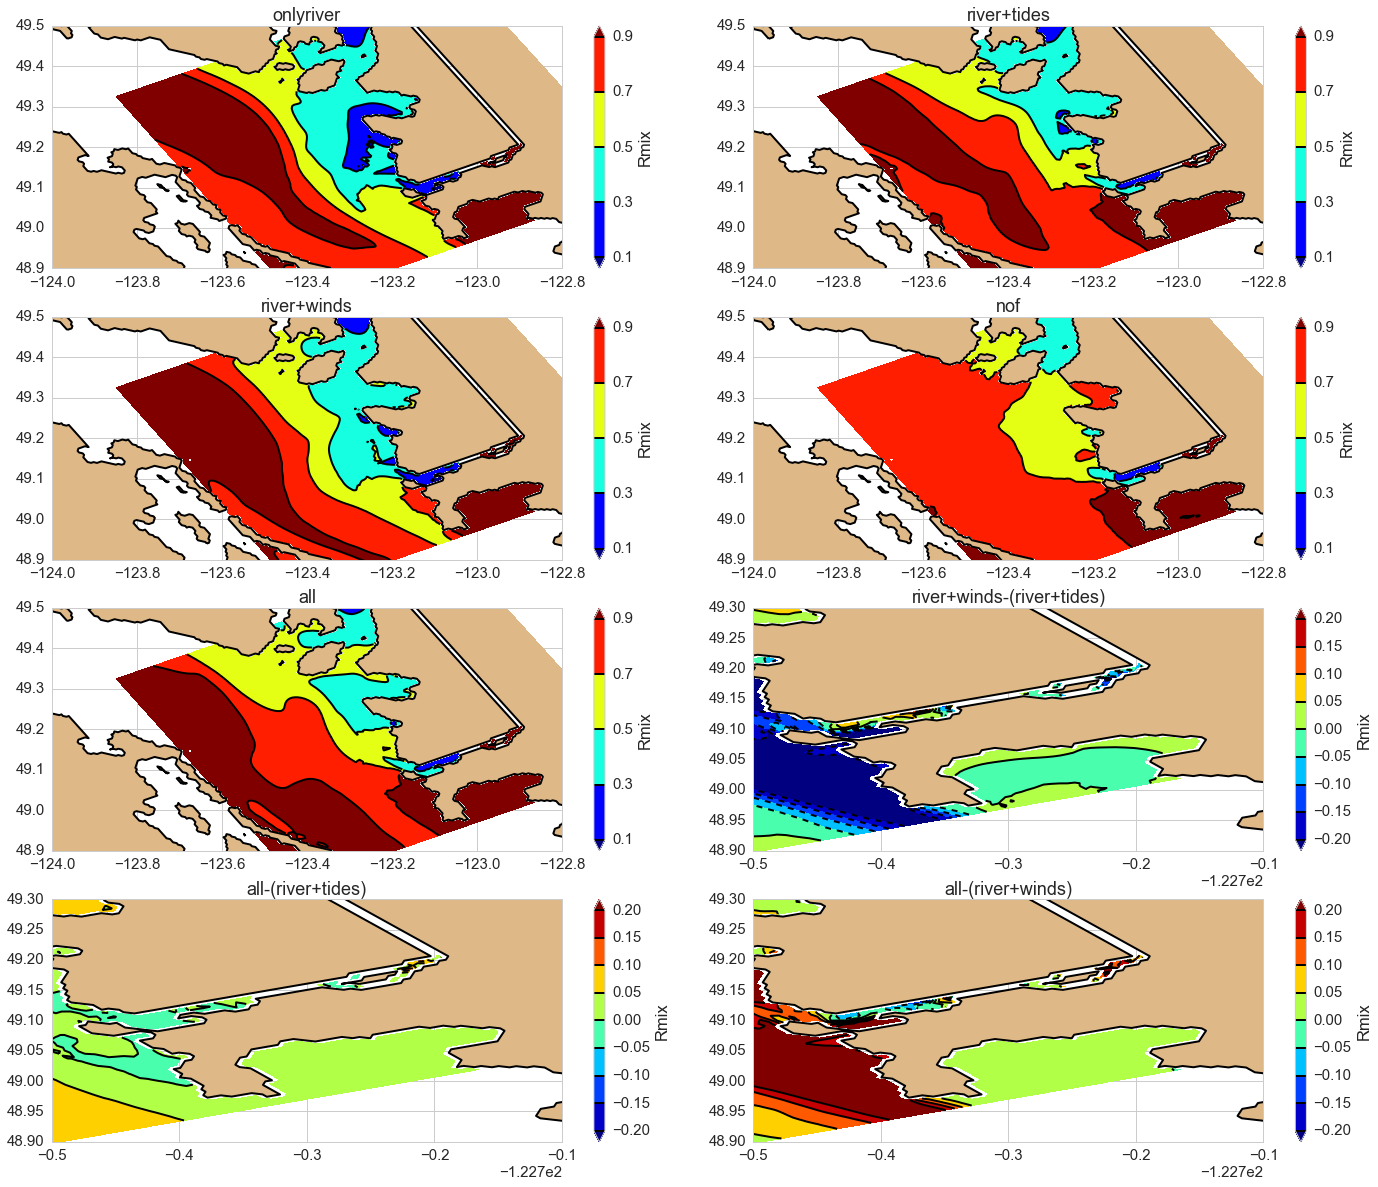

In [9]:
## weak
rmix_each(octriver_T,octnowind_T,octnotide_T,octnof_T,octall_T,48,143,10)

(48.95, 49.3)

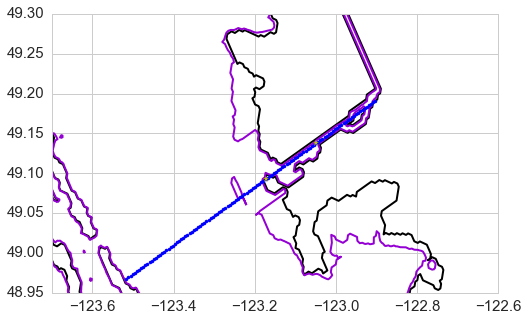

In [10]:
fig, ax = plt.subplots(1,1,figsize = (8,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
lon = octall_T.variables['nav_lon']
lat = octall_T.variables['nav_lat']
ax.plot(lon[36,4:123],lat[36,4:123],'b.')
ax.plot(lon[36,94],lat[36,94],'y*')
ax.plot(lon[36,70],lat[36,70],'y*')
ax.set_xlim([-123.7,-122.6])
ax.set_ylim([48.95,49.3])

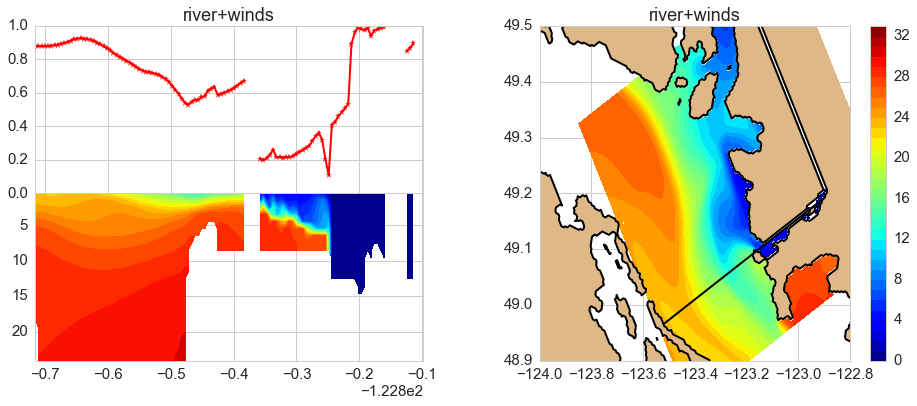

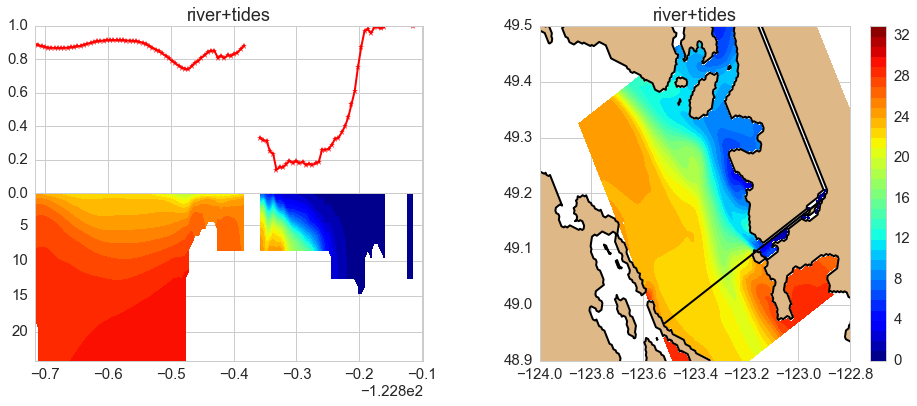

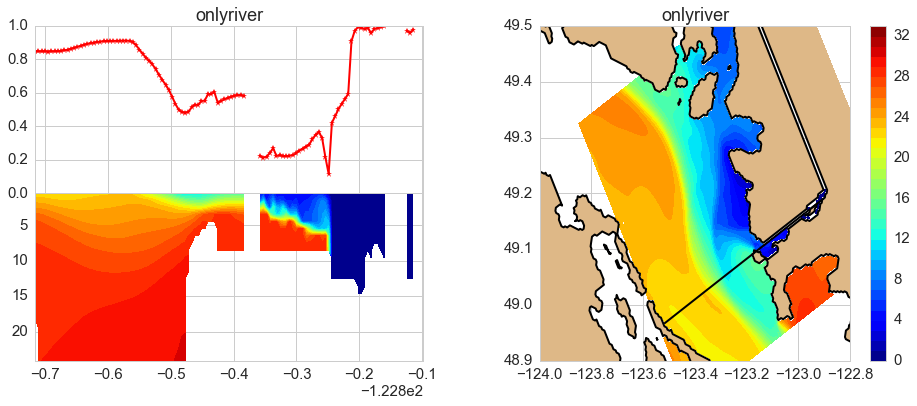

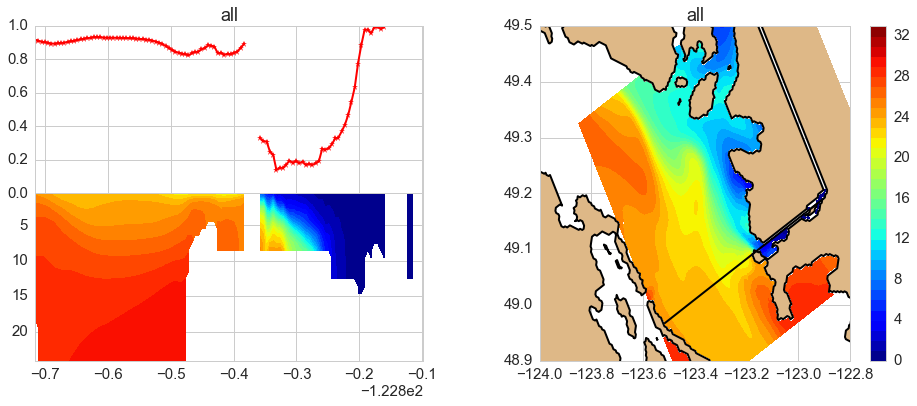

In [11]:
r_winds, S_ave_wind = salinity_profile_update(octnotide_T,48,143,10,np_mask,'river+winds')
r_tide,S_ave_tide = salinity_profile_update(octnowind_T,48,143,10,np_mask,'river+tides')
r_river,S_ave_river = salinity_profile_update(octriver_T,48,143,10,np_mask,'onlyriver')
r_all,S_ave_all = salinity_profile_update(octall_T,48,143,10,np_mask,'all')

* During low and moderate river flow in an averaged sense, river-induced mixing and wind overmix in the channel compared to all.

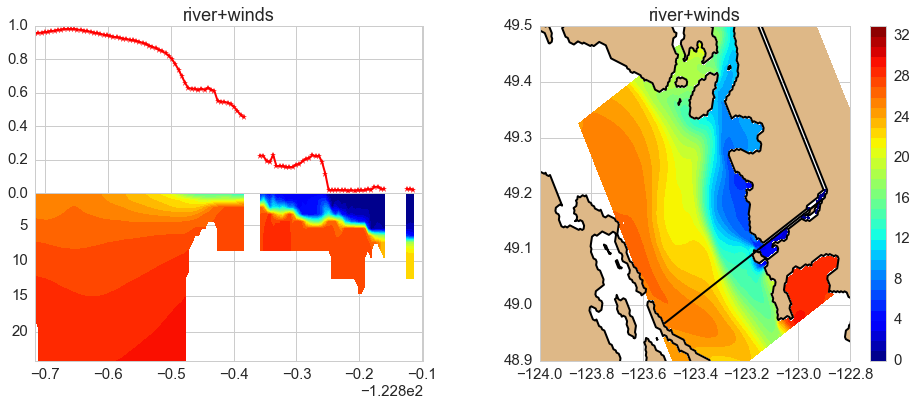

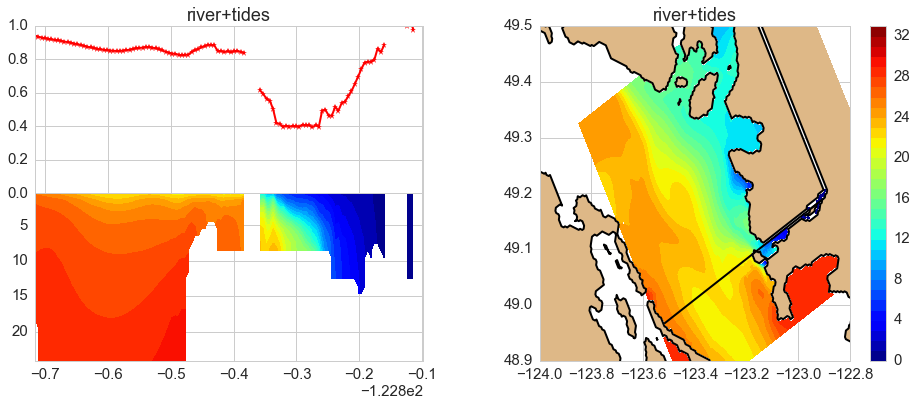

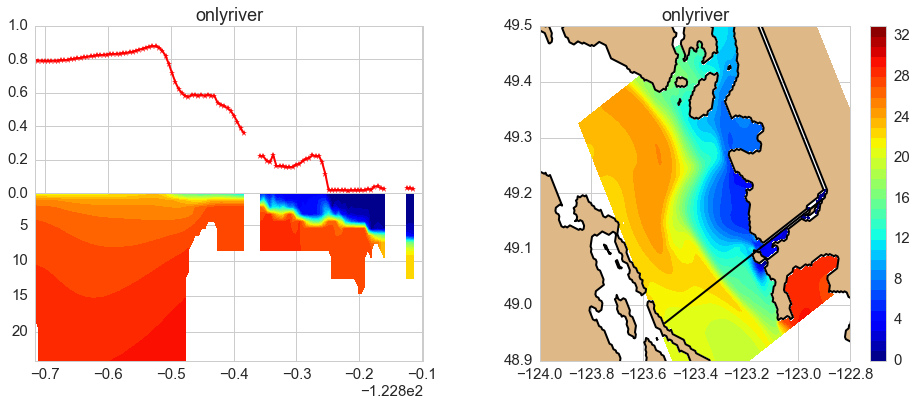

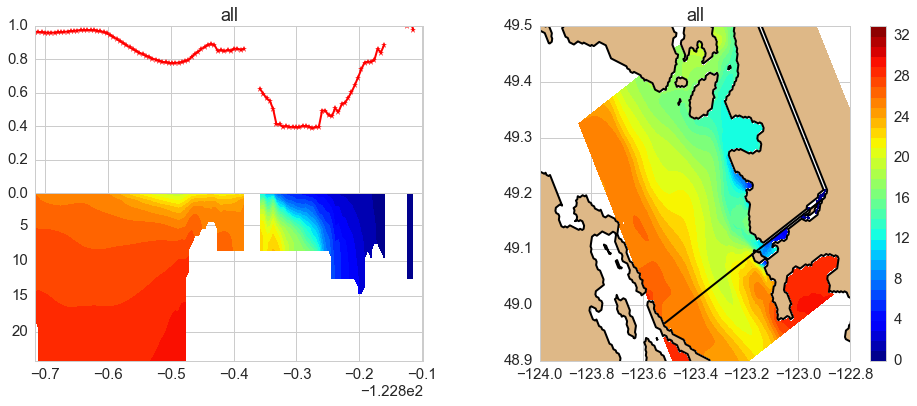

In [12]:
r_winds, S_ave_wind = salinity_profile_update(jannotide_T,168,239,10,np_mask,'river+winds')
r_tide,S_ave_tide = salinity_profile_update(jannowind_T,168,239,10,np_mask,'river+tides')
r_river,S_ave_river = salinity_profile_update(janriver_T,168,239,10,np_mask,'onlyriver')
r_all,S_ave_all = salinity_profile_update(janall_T,168,239,10,np_mask,'all')

* But under low river flow, tidal mixing controls in the river and decreases the unmixed region (RMIX< 0.1) to within 10 km of the mouth, which demonstrates Susan's hypothesis, with tides turning on, salt wedge intrusion decreased. But this only stands when the river flow is fairly weak, or the river runoff prevents the salt wedge to different extents.

* At instantaneous time

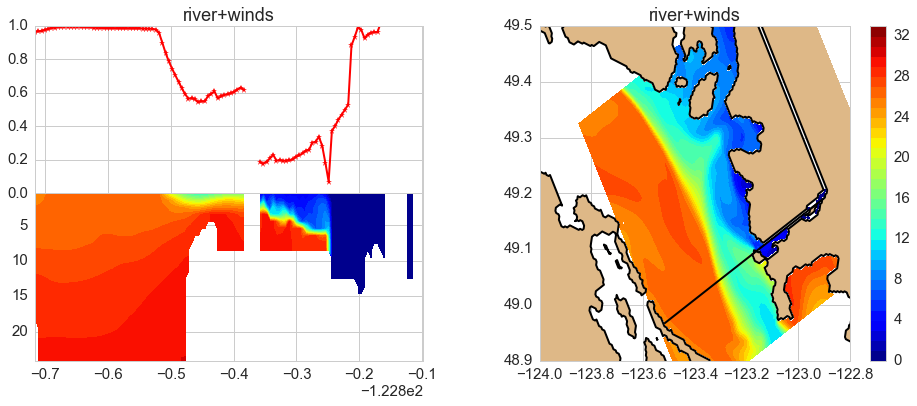

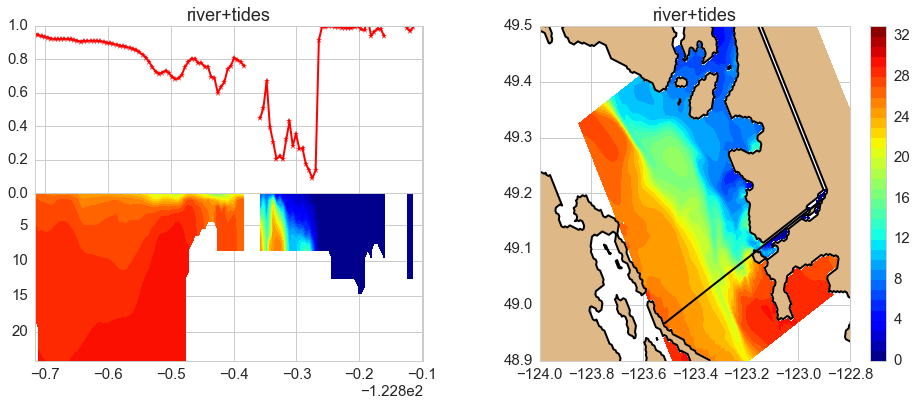

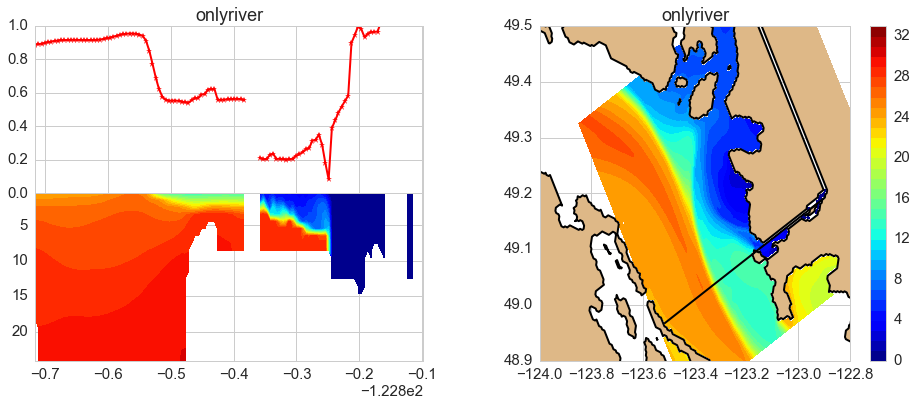

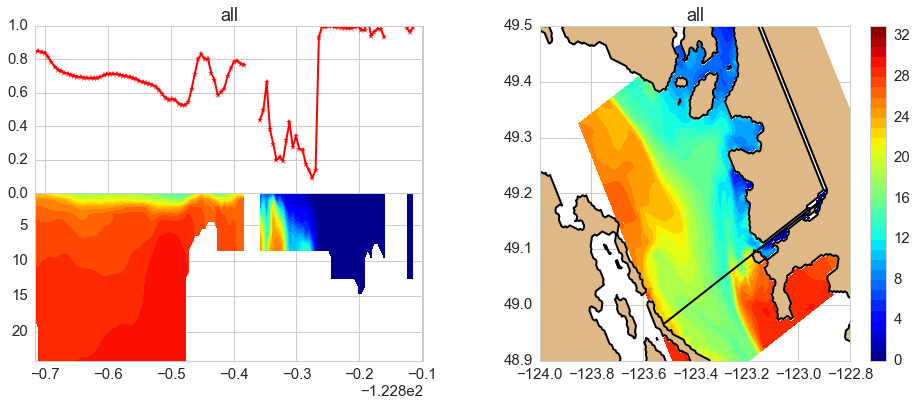

In [13]:
## instantaneous time in October, peak ebb
r_winds, S_ave_wind = salinity_profile_update(octnotide_T,196,196,10,np_mask,'river+winds')
r_tide,S_ave_tide = salinity_profile_update(octnowind_T,196,196,10,np_mask,'river+tides')
r_river,S_ave_river = salinity_profile_update(octriver_T,196,196,10,np_mask,'onlyriver')
r_all,S_ave_all = salinity_profile_update(octall_T,196,196,10,np_mask,'all')

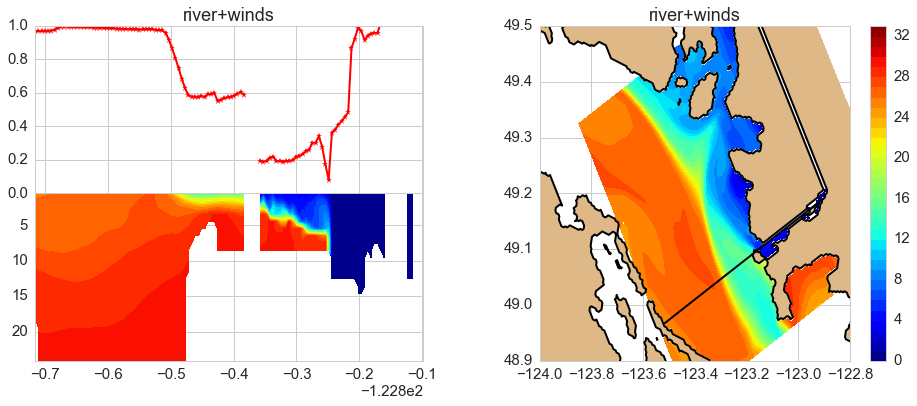

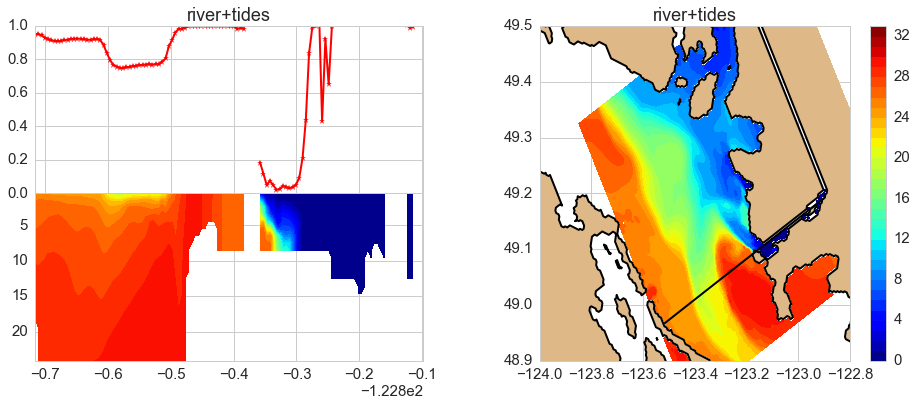

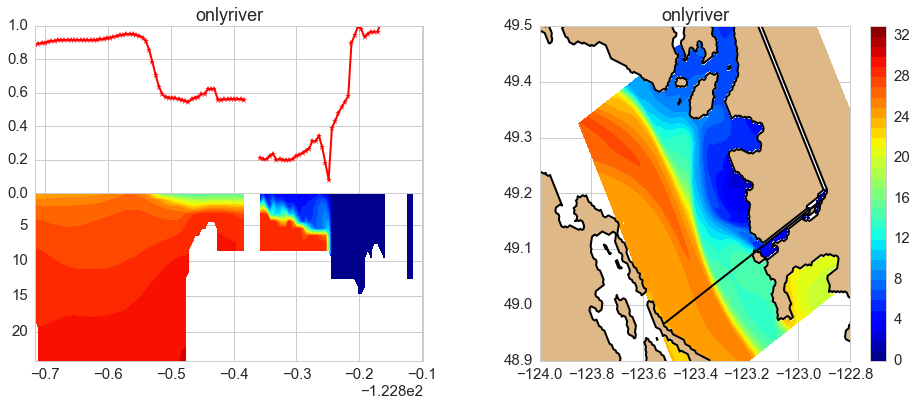

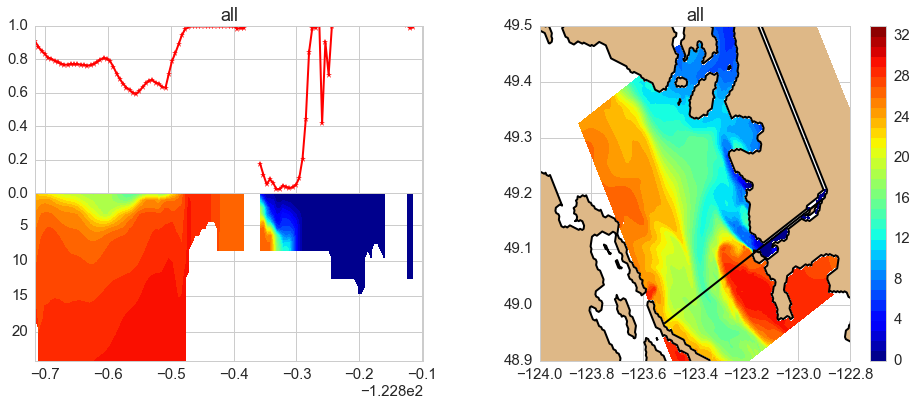

In [14]:
## instantaneous time in October, peak flood
r_winds, S_ave_wind = salinity_profile_update(octnotide_T,202,202,10,np_mask,'river+winds')
r_tide,S_ave_tide = salinity_profile_update(octnowind_T,202,202,10,np_mask,'river+tides')
r_river,S_ave_river = salinity_profile_update(octriver_T,202,202,10,np_mask,'onlyriver')
r_all,S_ave_all = salinity_profile_update(octall_T,202,202,10,np_mask,'all')